<a href="https://colab.research.google.com/github/sophiascarano/hybrid_quantum_classical_KiUNet/blob/main/broad_strokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# custom loss functions


In [ ]:
# will want to inherit from Loss
from tensorflow.keras.losses import Loss

class MyHuberLoss(Loss):
  # class variable - allows us to give it an intial value
  threshold = 1
  # initializes the object from the class
  def __init__(self, threshold):
    super().__init__()
    self.threshold = threshold
  # gets executed when an object is instantiated from the class
  def call(self, y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= self.threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss)

In [ ]:
# when you want to specify the loss function in model.compile:
model.compile(optimizer='sgd', loss=MyHuberLoss(threshold=1))

In [ ]:
# custom layers 

# inherit from keras' layer class

# I think I just have to set the "w" values (the random normal distribution times pi/2)
#   to be trainable=True?
# So when you inherit from the layer class, and your custom model inherits from the model class,
#     And you do model.compile, it autimatically scans and sees what it's allowed to train, and trains it?

test?

In [ ]:
import tensorflow as tf
import numpy as np
# inherit from this base class
from tensorflow.keras.layers import Layer

class SimpleDense(Layer):

    def __init__(self, units=32):
        '''Initializes the instance attributes'''
        super(SimpleDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="kernel",
            initial_value=w_init(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)

        # initialize the biases
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs):
        '''Defines the computation from inputs to outputs'''
        return tf.matmul(inputs, self.w) + self.b

In [ ]:
# now we can use our custom layer:

# declare an instance of the class
my_dense = SimpleDense(units=1)

# define an input and feed into the layer
x = tf.ones((1, 1))
y = my_dense(x)

# parameters of the base Layer class like `variables` can be used
print(my_dense.variables)

[<tf.Variable 'simple_dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.00564576]], dtype=float32)>, <tf.Variable 'simple_dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [ ]:
# let's try using it in a simple network:

# define the dataset
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)


# use the Sequential API to build a model with our custom layer
my_layer = SimpleDense(units=1)
model = tf.keras.Sequential([my_layer])

# configure and train the model
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=500,verbose=0)

# perform inference
print(model.predict([10.0]))

# see the updated state of the variables
print(my_layer.variables)

[[18.981653]]
[<tf.Variable 'simple_dense_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.9973408]], dtype=float32)>, <tf.Variable 'simple_dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([-0.9917554], dtype=float32)>]


# residual

In [ ]:
class CNNResidual(Layer):
  def __init__(self, layers, filters, **kwargs):
    super().__init__(*kwargs)
    self.hidden = [Conv2D(filters, (3,3), activation='relu')
                    for _ in range(layers)]
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x) #main path through residual network block
    return inputs + x #the input is appended to the results - skip connection analogy

In [ ]:
# identity block within residual
class IdentityBlock(tf.keras.Model):
  def __init__(self, filters, kernel_size):
    super(IdentityBlock, self).__init__(name='')

    self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization()

    self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
    self.bn2 = tf.keras.layers.BatchNormalization()

    self.activation = tf.keras.layers.Activation('relu')
    self.add = tf.keras.layers.Add()

  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.activation(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)

    x = self.add([x, input_tensor])
    x = self.activation(x)

    return x

In [ ]:
# full (mini) resnet:

class ResNetMini(tf.keras.Model):
  def __init__(self, num_classes):
    super(ResNetMini, self).__init__()
    self.conv = tf.keras.Conv2D(64, 7, padding='same')
    self.bn = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.Activation('relu')
    self.max_pool = tf.keras.layers.MaxPool2D((3,3))
    self.identity1a = IdentityBlock(64, 3)
    self.identity1b = IdentityBlock(64, 3)
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.bn(x)
    x = self.activation(x)
    x = self.max_pool(x)

    x = self.identity1a(x)
    x = self.identity1b(x)

    x = self.global_pool(x)
    x = self.classifier(x)

    return x

In [ ]:
# now actually run it I guess?

resnet_mini = ResNetMini(10)
resnet_mini.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
dataset = tfds.load('mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(preprocess).batch(32)
resnet_mini.fit(dataset, epochs=1)

# overall

In [ ]:
# CLASSICAL NETWORK
# Regular conv block with relu activation

# U-Net encoder block
# U-Net decoder block
# U-Net encoder
# U-Net decoder
# U-Net bottleneck (unlikely necessary for CRFB, but still use here)

# Ki-Net encoder block
# Ki-Net decoder block
# Ki-Net encoder
# Ki-Net decoder

# 1x1 Conv block connecting outputs of both networks


# HYBRID QUANTUM NETWORK
# Qiskit conv block

# (Q) U-Net encoder block
# (Q) U-Net decoder block
# (Q) U-Net encoder
# (Q) U-Net decoder
# (Q) U-Net bottleneck (unlikely necessary for CRFB, but still use here)

# (Q) Ki-Net encoder block
# (Q) Ki-Net decoder block
# (Q) Ki-Net encoder
# (Q) Ki-Net decoder


# CRFB IMPLEMENTATION - (IF TIME)
# CRFB block
# Appropriat eoutput implementation into structures above

# towards quantum

In [ ]:
import tensorflow as tf
import numpy as np
# inherit from this base class
from tensorflow.keras.layers import Layer

import matplotlib.pyplot as plt


In [ ]:
myarr = np.ones((3,3)) * 2
w_init = tf.random_normal_initializer()
w = tf.Variable(name="kernel",
                      initial_value=w_init(shape=(3,3),
                                          dtype='float32'),
                      trainable=True)

tf_arr = tf.cast(myarr, tf.float32)
dot_ab = tf.matmul(tf_arr, w)
print(type(w))
print(type(myarr))
print(tf_arr)
print(w)
print(tf_arr * w)
dot_ab

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
<class 'numpy.ndarray'>
tf.Tensor(
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]], shape=(3, 3), dtype=float32)
<tf.Variable 'kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.04291903,  0.04835445,  0.00866976],
       [-0.07053826,  0.06046928, -0.03562165],
       [-0.06709777, -0.01752293,  0.04469826]], dtype=float32)>
tf.Tensor(
[[ 0.08583806  0.0967089   0.01733953]
 [-0.14107652  0.12093856 -0.07124331]
 [-0.13419554 -0.03504586  0.08939651]], shape=(3, 3), dtype=float32)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-0.18943399,  0.1826016 ,  0.03549273],
       [-0.18943399,  0.1826016 ,  0.03549273],
       [-0.18943399,  0.1826016 ,  0.03549273]], dtype=float32)>

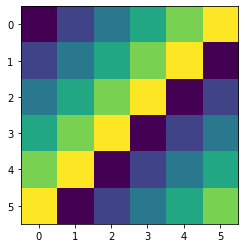

4

In [ ]:
# but the dot product isn't even what I'm doing
# the weights are what's used in the Ry calculations
# the expectation values for each pixel after the PQC are added up
# how to get that value in correct location on image?
ex_image = np.array([[0, 1, 2, 3, 4, 5,
                      1, 2, 3, 4, 5, 0,
                      2, 3, 4, 5, 0, 1,
                      3, 4, 5, 0, 1, 2,
                      4, 5, 0, 1, 2, 3,
                      5, 0, 1, 2, 3, 4]]) + 1
example_image = np.reshape(ex_image, (6, 6))
plt.imshow(example_image)
plt.show()

type(example_image)

example_image[1][2]

In [ ]:
def conv_operation_test(this_block, weights_list):
  '''
  This function takes a list of the pixel values of the block we are currently
    working with from the image

  Args:
  this_block: list
  ex. 3x3 section from image is "a":
  a = [ 1   2   3
        2   3   4
        3   4   5]
  this_block = [1, 2, 3, 2, 3, 4, 3, 4, 5]

  weights_list: the flattened 3x3 array of weights as a list
  '''
  block_array = np.array(this_block)
  weights_array = np.array(weights_list)
  
  operation = block_array * weights_array

  return operation

In [ ]:
def feature_map_dims(img_width, img_height, filter_dims=(3, 3), padding=1, stride=1):
  '''
  This function calculates the output dimensions of the feature map based on
    well-known equation.
  '''
  # do 2*padding because this is assuming padding is equal on ALL sides of img
  feature_map_width = (img_width - filter_dims[0] + (2*padding) + 1) / stride
  feature_map_height = (img_height - filter_dims[1] + (2*padding) + 1) / stride
  return (int(feature_map_width), int(feature_map_height))

In [ ]:
def get_single_feature_map(input_img, weights_list, filter_size=3, padding=1, stride=1):
  '''
  This is a function that takes an image and performs a convolution operation

  Args: 
  input_img - the input image (numpy array)
  weights_list - the values of the weights (mxn length list)
  filter_size - the size=m=n dimensions of the square filter/kernel (int)
  padding - the number of padding layers that will be equally applied to all sides of the image (int)
  stride - the stride of the kernel window

  Returns: the feature map
  '''
  # apply padding to image
  img = np.pad(input_img, ((padding,padding), (padding,padding)), 'constant', constant_values=((0,0), (0,0)))
  weights = weights_list
  w = img.shape[0] # width of padded image
  h = img.shape[1] # height
  
  fm_width = feature_map_dims(input_img.shape[0], input_img.shape[1])[0]
  fm_height = feature_map_dims(input_img.shape[0], input_img.shape[1])[1]

  # this is the part that scans the filter/kernel/window over the image
  # at each scan, it performs the convolution for that window
  # and appends the sum of the resulting matrix to the feature map list
  feature_map_list = []
  for i in range(0, fm_width):
    for j in range(0, fm_height):
      this_block = []
      for m in range(i, i+filter_size):
        for n in range(j, j+filter_size):
          this_block.append(img[m][n])
      # do the convolution
      conv_output = conv_operation_test(this_block, weights)
      # sum all the values in the array
      feature_map_list.append(np.sum(conv_output))
  
  # once you have the feature map in a list, turn it into an array
  # and reshape it for visualization purposes
  feature_map_array = np.array(feature_map_list)
  feature_map = np.reshape(feature_map_array, (fm_width, fm_height))
  return feature_map


6

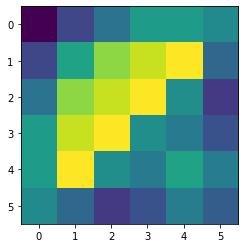

In [ ]:
weights = [1, 2, 3, 2, 3, 1, 3 ,1, 2]
img1 = get_single_feature_map(example_image, weights)
plt.imshow(img1)
img1.shape[0]

In [ ]:
# implement depth
def get_one_conv_output(img_list, input_channel_weights_list, input_depth, desired_operation='addition'):
  '''
  This function takes a list of input images and a list of each image's 
    corresponding weights list (the weights that make up the feature map)
  
  Args:
  img_list (list of np.array objects): images in their np.array form
  input_channel_weights_list (list): nested lists of the values of the weights 
          corresponding to that index's image in img_list [[1, ..., 9], [1, ...,9], ... x num_input_channels]
  input_depth (int): makes sure that there are a correct number of images and weight lists
  desired_operation (str): either 'addition' or 'average' to indicate which pixelwise operation for the feature maps
  '''
  if input_depth != len(img_list):
    print("image list length not equal to input depth")
  elif input_depth != len(input_channel_weights_list):
    print("input_channel_weights_list length not equal to input depth")
  else:
    # list of all the feature map arrays corresponding to the operation for that associated image and filter
    all_feature_maps = [] 
    for i in range(input_depth):
      # get each feature map given that image input and its associated weights
      this_feature_map = get_single_feature_map(input_img = img_list[i], 
                                                weights_list = input_channel_weights_list[i]
                                                )
      all_feature_maps.append(this_feature_map)
    
    # once you have all the feature maps, can either take the pixelwise average or addition of all the maps
    final_output = sum(all_feature_maps)
    if desired_operation == 'addition':
      return final_output #for additon
    else:
      return final_output / input_depth #should be an elementwise division of pixel value / num_channels (aka input depth)
    # elif desired_operation == 'average':
    #   return final_output / depth #for average
    # else print('unrecognized desired_operation')

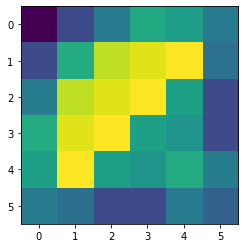

In [ ]:
my_img_list = []
for i in range(2):
  my_img_list.append(example_image)
my_weights_list1 = [weights, [3, 2, 1, 2, 1, 3, 1, 3, 2]]
my_weights_list2 = [weights, [3, 1, 2, 2, 3, 1, 1, 2, 3]]
my_weights_list3 = [weights, weights]
kl1 = get_one_conv_output(img_list=my_img_list, list_of_weights_list=my_weights_list1, input_depth=2)
kl2 = get_one_conv_output(img_list=my_img_list, list_of_weights_list=my_weights_list2, input_depth=2)
#plt.imshow(kl[0])
#type(kl[0])
plt.imshow(kl2)

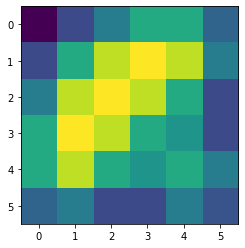

In [ ]:
plt.imshow(kl1)

In [ ]:
def custom_batchnorm(input_imgs, current_layer, all_batchnorm_params):
  '''
  This is a function that, given a batch of input images, rescales each pixel to
    be between 0-1 based on the min and max values across the entire batch of 
    input images
    Nope, it's actually according to the equation found at link below.
  NOTE: this would go after ReLU, but since nonlinearity is baked in to quantum 
    convolution, there is no activation function necessary
  
  Args:
  input_imgs (list): this is a list of np.arrays representing each image
  current_layer (int): helps with keeping track of which params to train
  all_batchnorm_params (list): list of tuples, with the index of the tuple 
    corresponding to the current layer. So for layer 1, you would access the first 
    tuple in the list: [(scale_param_1, shift_param_1), ...]
  '''
  #couldn't find an easier way to do this min/max part. come back
  # make a list of all max values for each array, then find max of that list
  max_pixel = max([img_array.max() for img_array in input_imgs])
  # and same for min
  min_pixel = min([img_array.min() for img_array in input_imgs])

  # equation
  # concat all arrays to find mean (could find max and min from this too)
  all_arrays = np.concatenate(input_imgs)
  mean = np.mean(all_arrays)
  stdev = np.std(all_arrays)
  scale = all_batchnorm_params[current_layer][0]
  shift = all_batchnorm_params[current_layer][1]

  #based on equation from link: https://d2l.ai/chapter_convolutional-modern/batch-norm.html
  new_array_list = [scale * ((arr - mean) / stdev) + shift for arr in input_imgs]

  return new_array_list
  

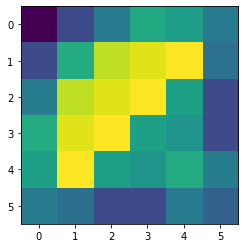

In [ ]:
my_img_list = [kl1, kl2]
all_batchnorms = [[1, 1], [1, 1]]
new_arr_lis = custom_batchnorm(my_img_list, 0, all_batchnorms)
plt.imshow(new_arr_lis[1])

In [ ]:
def one_conv_layer_no_batchnorm(input_images, this_layer_weights_list, num_output_channels, num_input_channels):
  '''
  This is a function that takes all the input images, gets the conv output for each set of images
    based on the assiciated weights for that image in that iteration, and does this
    for a number of times and a number of different sets of weights equal to the num_output_channels

  Args:
  input_images (list): list of np.arrays that represent each image
  this_layer_weights_list (list): list of all the input_channel_weights_lists
    for each of the input channels in that layer
    has length = number of output channels
    but length of each nested list = number of input channels
  num_output_channels (int): the number of input channels.
    should be equivalent to the length of the list this_layer_weights_list
  num_input_channels (int): the number of input channels.
    should be equivalent to the length of each list nested inside this_layer_weights_list
    should also be equivalent to the number of input images??
  '''
  #make sure the length of each list inside this_layer_weights_list is correct
  lengths_of_nested_lists = [len(this_layer_weights_list[i]) for i in range(len(this_layer_weights_list))]
  if len(this_layer_weights_list) != num_output_channels:
    print("make sure the length of your weights list for this layer is the same as the number of output channels")
  elif max(lengths_of_nested_lists) != min(lengths_of_nested_lists) != num_input_channels:
    print('make sure the length of each of the nested weights lists is the same as the number of input channels')
  else:
    all_convolved_outputs = []
    for i in range(num_output_channels):
      input_weights_this_iteration = this_layer_weights_list[i]
      this_iteration_output = get_one_conv_output(img_list=input_images, 
                                                  input_channel_weights_list=input_weights_this_iteration, 
                                                  input_depth=num_input_channels, #COME BACK this will maybe be a hard-coded param? nah it's fine/
                                                  desired_operation='addition')
      all_convolved_outputs.append(this_iteration_output)
    # these are not batch-normed yet so that will hav to be a separate step
    return all_convolved_outputs

   #get_one_conv_output(img_list, input_channel_weights_list, input_depth, desired_operation='addition')
                                                            

In [ ]:
def one_conv_layer_with_batchnorm(input_images, 
                                  this_layer_weights_list, 
                                  num_output_channels,
                                  num_input_channels,
                                  current_layer,
                                  all_batchnorm_params):
  


custom_batchnorm(input_imgs, current_layer, all_batchnorm_params)

In [ ]:
my_weights_list1 = [weights, [3, 2, 1, 2, 1, 3, 1, 3, 2]]
my_weights_list2 = [weights, [3, 1, 2, 2, 3, 1, 1, 2, 3]]
my_weights_list3 = [weights, weights]

my_img_list = [kl1, kl2]
this_weights_list = [my_weights_list1, my_weights_list2, my_weights_list3] #3 outputs I guess

test_lis = one_conv_layer_no_batchnorm(input_images=my_img_list, 
                            this_layer_weights_list=this_weights_list, 
                            num_output_channels=3, 
                            num_input_channels=2)

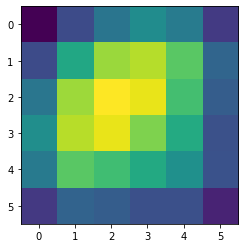

In [ ]:
my_img_list = [kl1, kl2]
all_batchnorms = [[1, 1], [1, 1]]
new_arr_lis = custom_batchnorm(test_lis, 0, all_batchnorms)
plt.imshow(new_arr_lis[1])

In [ ]:
my_weights_list = []
for i in range(2):
  my_weights_list.append(weights)

my_img_list = []
for i in range(2):
  my_img_list.append(example_image)

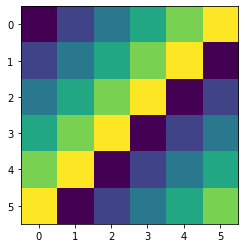

In [ ]:
plt.imshow(example_image)

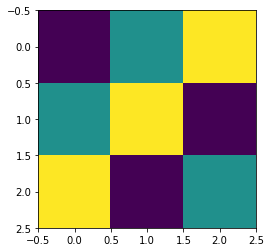

In [ ]:
weights_arr = np.array(weights)
weights_arr = np.reshape(weights_arr, (3,3))
plt.imshow(weights_arr)

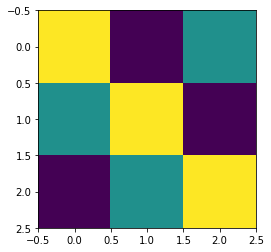

In [ ]:
weights_arr = np.array([3, 1, 2, 2, 3, 1, 1, 2, 3])
weights_arr = np.reshape(weights_arr, (3,3))
plt.imshow(weights_arr)

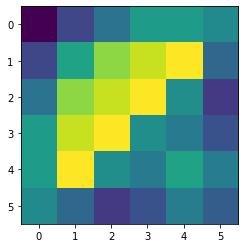

In [ ]:
my_img_list = []
for i in range(2):
  my_img_list.append(example_image)
#my_weights_list = [weights, [3, 2, 1, 2, 1, 3, 1, 3, 2]]
#my_weights_list = [weights, [3, 1, 2, 2, 3, 1, 1, 2, 3]]
my_weights_list = [weights, weights]
kl = get_one_conv_output(img_list=my_img_list, list_of_weights_list=my_weights_list, input_depth=2)
#plt.imshow(kl[0])
#type(kl[0])
plt.imshow(kl)

In [ ]:
num_conv_layers = 4
for layer in num_conv_layers:
  

In [ ]:
# now for multiple outputs
#Layer 1, Output channel 1, Input channel 1
l1o1i1 = weights
l1o1i2 = weights
l1o1i3 = weights

l1o2i1 = weights
final_weights_list = [[[[3, 2, 1, 2, 1, 3, 1, 3, 2], [3, 2, 1, 2, 1, 3, 1, 3, 2]]]]

In [ ]:
number_of_weight_lists = (2*32 + 2*32*64 + 2*64*128 + 128*128)
number_of_weight_lists

36928

In [ ]:
total_num_weights = 9*number_of_weight_lists
total_num_weights

332352

To do:

For this custom, from scratch cnn that doesn't use tensorflow or torch
- figure out how to get MULTIPLE feature maps, all with a different set of weights that I want the model to learn
  - The function above is just to generate a single feature map given a list of weights (and the image) as the input
  - FIGURE OUT HOW TO IMPLEMENT DEPTH!!!
  - If you have 6 filters of depth 1 (grayscale image) in the first layer, in the second layer you need each of the filters (say, 16) to have a DEPTH of 6 instead of 1.
- Also, for batch norm: need a function to manually code the normalization of each individual feature map (to be on a 0-1 scale, based on max and min pixels in the feature map)
  - These are the feature maps that will be implemented into the next layer
  - All need to be between 0-1 because of the quantum stuff.
  - This shouldn't be too hard
- Also need to implement a max pooling function somewhere in there. Hopefully Keras can handle that.
- And an updampling function. I think keras can do that too

Depth problem: https://cs231n.github.io/convolutional-networks/
- To get around the problem of depth dramatically increasing the number of neurons (weights) required, use **parameter sharing scheme**:
  - May not have to do this if not too many weights
- visualization of filters, weights, etc: https://poloclub.github.io/cnn-explainer/

TO DO:
- Hard-code structure, and use a function for the filter convolution operation
- maybe employ some visualization scheme for this

WILL NOT WORK:
- Then, make a master tester function imitating LeNet-5 except use padding to conserve size (will need for skip connections in U-Net later):
  - start with grayscale 32x32x1
  - CONV1 with 6 filters (depth 1) 32x32x6
  - Max pool f=2, s=2 16x16x6
  - CONV2 with 16 filters (depth 6) 16x16x16
  - Max pool f=2, s=2 8x8x16
  - fully connect

WHAT I ACTUALLY NEED TO DO: small-scale segmentation. lol. not really a thing
- Start small:
  - Grayscale 32x32x1
  - CONV1 with 6 filters (depth 1) 32x32x6

Batchnorm nnotes:


In [ ]:
def tester():
  img_width = 6
  img_height = 6
  filter_size = 3
  #weights_list = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]
  weights_list = [1, 2, 3, 2, 3, 1, 3 ,1, 2]
  v = img_width
  h = img_height
  feature_map = []
  for i in range(0, v-filter_size+1):
    for j in range(0, h-filter_size+1):
      this_block = []
      for m in range(i, i+filter_size):
        for n in range(j, j+filter_size):
          this_block.append(example_image[m][n])
      # do the elementwise multiplication of the current block * the weights matrix
      # this is what will be replaced by 
      conv_output = conv_operation_test(this_block, weights_list)
      # sum all the values in the array
      feature_map_element = np.sum(conv_output)
      feature_map.append(feature_map_element)

  return feature_map

In [ ]:
tester()

[36, 54, 60, 66, 54, 60, 66, 30, 60, 66, 30, 24, 66, 30, 24, 36]

In [ ]:
X = np.array(tester())
X = np.reshape(X, (4,4))
X

array([[36, 54, 60, 66],
       [54, 60, 66, 30],
       [60, 66, 30, 24],
       [66, 30, 24, 36]])

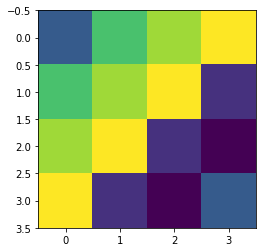

In [ ]:
plt.imshow(X)
plt.show()

In [ ]:
def tester():
  img_width = 6
  img_height = 6
  filter_size = 3
  weights_list = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]
  v = img_width
  h = img_height
  list_of_blocks = []
  for i in range(0, v-filter_size+1):
    for j in range(0, h-filter_size+1):
      this_block = []
      for m in range(i, i+filter_size):
        for n in range(j, j+filter_size):
          this_block.append(example_image[m][n])
      list_of_blocks.append(this_block)

  return list_of_blocks

In [ ]:
tester()

[[0, 1, 2, 1, 2, 3, 2, 3, 4],
 [1, 2, 3, 2, 3, 4, 3, 4, 5],
 [2, 3, 4, 3, 4, 5, 4, 5, 0],
 [3, 4, 5, 4, 5, 0, 5, 0, 1],
 [1, 2, 3, 2, 3, 4, 3, 4, 5],
 [2, 3, 4, 3, 4, 5, 4, 5, 0],
 [3, 4, 5, 4, 5, 0, 5, 0, 1],
 [4, 5, 0, 5, 0, 1, 0, 1, 2],
 [2, 3, 4, 3, 4, 5, 4, 5, 0],
 [3, 4, 5, 4, 5, 0, 5, 0, 1],
 [4, 5, 0, 5, 0, 1, 0, 1, 2],
 [5, 0, 1, 0, 1, 2, 1, 2, 3],
 [3, 4, 5, 4, 5, 0, 5, 0, 1],
 [4, 5, 0, 5, 0, 1, 0, 1, 2],
 [5, 0, 1, 0, 1, 2, 1, 2, 3],
 [0, 1, 2, 1, 2, 3, 2, 3, 4]]

In [ ]:
X = np.array(tester())
X.shape

(16, 9)

In [ ]:
def tester():
  img_width = 6
  img_height = 6
  filter_size = 3
  weights_list = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]
  v = img_width
  h = img_height
  list_of_concats = []
  for j in range(h):
    for i in range(v):
      # this is one block
      this_filter = weights_list
      start_v = i
      end_v = start_v + filter_size
      start_h = j
      end_h = start_h + filter_size
      this_block =[]
      for m in range(start_h, end_h):
        for n in range(start_v, end_v):
          this_block.append(example_image[m][n])
      #mult_mat = this_block * this_filter
      #dot_result = np.sum(mult_mat)
      list_of_concats.append(this_block)

  return list_of_concats

In [ ]:
tester()

In [ ]:
def tester():
  img_width = 6
  img_height = 6
  filter_size = 3
  weights_list = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]
  v = img_width
  h = img_height
  list_of_concats = []
  for j in range(h):
    for i in range(v):
      # this is one block
      this_filter = weights_list
      start_v = i
      end_v = start + filter_size
      start_h = j
      end_h = start + filter_size
      this_block =[]
      for m in range(start_h, end_h):
        for n in range(start_v, end_v):
          this_block.append(example_image[m][n])
      #mult_mat = this_block * this_filter
      #dot_result = np.sum(mult_mat)
      list_of_concats.append(this_block)

  return list_of_concats

In [ ]:
tester()

In [ ]:
def tester():
  img_width = 6
  img_height = 6
  filter_size = 3
  weights_list = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]
  v = img_width
  h = img_height
  list_of_concats = []
  for j in range(h):
    for i in range(v):
      # this is one block
      this_filter = weights_list
      start_v = i
      end_v = start + filter_size
      start_h = j
      end_h = start + filter_size
      this_block =[]
      for m in range(start_h, end_h):
        for n in range(start_v, end_v):
          this_block.append(example_image[m][n])
      mult_mat = this_block * this_filter
      dot_result = np.sum(mult_mat)
      list_of_concats.append(dot_result)

  return list_of_concats

In [ ]:
tester()

In [ ]:

filter_size = 3
start = 0
end = start + filter_size
my_lis =[]
for m in range(start, end):
  for n in range(start, end):
    my_lis.append(example_image[m][n])
my_lis

[0, 1, 2, 1, 2, 3, 2, 3, 4]

# custom weight initializer

In [ ]:
class QConv(Layer):
  def __init__(self, filter_shape=3):
    '''Initializes the instance attributes'''
    super(QConv, self).__init__()
    self.filter_shape = filter_shape #instead of units

  def build(self):
    '''Create the state of the layer (weights)'''
    #initialize the weights
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(name="kernel",
                         initial_value=w_init(shape=(self.filter_shape, self.filter_shape),
                                              dtype='float32'),
                         trainable=True)
  def call(self):
    '''Defines the computation from inputs to outputs'''
    operation = 

In [ ]:
test = QConv()
print(test)

In [ ]:
def q_conv(image, filter_dims=(3,3), padding=2, stride=1):
  filter_weights = np.random.rand(3,3)

In [ ]:
import tensorflow as tf
import numpy as np
# inherit from this base class
from tensorflow.keras.layers import Layer

class SimpleDense(Layer):

    def __init__(self, units=32):
        '''Initializes the instance attributes'''
        super(SimpleDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="kernel",
            initial_value=w_init(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)

        # initialize the biases
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs):
        '''Defines the computation from inputs to outputs'''
        return tf.matmul(inputs, self.w) + self.b

In [ ]:
#!pip install qiskit

     |████████████████████████████████| 6.0MB 11.1MB/s 
     |████████████████████████████████| 18.0MB 189kB/s 
     |████████████████████████████████| 235kB 56.7MB/s 
     |████████████████████████████████| 215kB 45.9MB/s 
     |████████████████████████████████| 2.1MB 49.6MB/s 
     |████████████████████████████████| 1.0MB 52.6MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 194kB 70.2MB/s 
     |████████████████████████████████| 112kB 72.7MB/s 
     |████████████████████████████████| 614kB 46.5MB/s 
     |████████████████████████████████| 3.2MB 34.7MB/s 
     |████████████████████████████████| 6.3MB 40.9MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.0-cp37-none-any.whl size=10489 sha256=e442bfb1b6ee2a93215ca8508de75e88dcfb41db78cce2479c88fed1c6b3aff0
  Stored in directory: /root/.cache/pip/wheels/77/b5/a2/e88ddacf664ca9d2d30275664482d128c3e28b1fd554124a9d
  Created wheel for python-constraint: filename=python_constraint-1.4.0

In [ ]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-ozdjqyek
  Running command git clone -q https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-ozdjqyek
  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-cp37-none-any.whl size=16953 sha256=b569ac8dffd11bec45b387ba1dfa69fda6287ce5c135e2228bbedb4cce9279a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-2lddt5el/wheels/0c/57/26/1c12886a219af04a38ca1e674fdeeff40b8a5963326ba3c71a
Successfully built qiskit-textbook


In [ ]:
from qiskit import QuantumCircuit, Aer, assemble
from math import pi
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [ ]:
qc = QuantumCircuit(3)
# Apply H-gate to each qubit:
for qubit in range(3):
    qc.h(qubit)
# See the circuit:
qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

In [ ]:
# Let's see the result
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
final_state = svsim.run(qobj).result().get_statevector()

# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(final_state) instead.
from qiskit_textbook.tools import array_to_latex
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ X ├
     └───┘

In [ ]:
usim = Aer.get_backend('unitary_simulator')
qobj = assemble(qc)
unitary = usim.run(qobj).result().get_unitary()

In [ ]:
# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(unitary) instead.
from qiskit_textbook.tools import array_to_latex
array_to_latex(unitary, pretext="\\text{Circuit = }\n")

<IPython.core.display.Math object>

In [ ]:
from IPython.display import Math
from google.colab.output._publish import javascript
url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"

javascript(url=url)

In [ ]:
Math(r"\begin{bmatrix} 0 & 0 & \tfrac{1}{\sqrt{2}} & \tfrac{1}{\sqrt{2}}\\ 0 & 0 & \tfrac{1}{\sqrt{2}} & -\tfrac{1}{\sqrt{2}} \\ \tfrac{1}{\sqrt{2}} & \tfrac{1}{\sqrt{2}} & 0 & 0 \\ \tfrac{1}{\sqrt{2}} & -\tfrac{1}{\sqrt{2}} & 0 & 0 \end{bmatrix}")

<IPython.core.display.Math object>

In [ ]:
qc = QuantumCircuit(2)
qc.x(1)
qc.draw()

q_0: ─────
     ┌───┐
q_1: ┤ X ├
     └───┘

In [ ]:
# Simulate the unitary
usim = Aer.get_backend('unitary_simulator')
qobj = assemble(qc)
unitary = usim.run(qobj).result().get_unitary()
# Display the results:
array_to_latex(unitary, pretext="\\text{Circuit = } ")

<IPython.core.display.Math object>

In [ ]:
Math(r"\begin{bmatrix}  0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 1  \\ 1 & 0 & 0 & 0  \\ 0 & 1 & 0 & 0 \end{bmatrix}")

<IPython.core.display.Math object>

In [ ]:
qc = QuantumCircuit(2)
# Apply CNOT
qc.cx(0,1)
# See the circuit:
qc.draw()


q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

In [ ]:
# Simulate the unitary
usim = Aer.get_backend('unitary_simulator')
qobj = assemble(qc)
unitary = usim.run(qobj).result().get_unitary()
# Display the results:
array_to_latex(unitary, pretext="\\text{Circuit = } ")

<IPython.core.display.Math object>

In [ ]:
Math(r"\begin{bmatrix}  1 & 0 & 0 & 0  \\ 0 & 0 & 0 & 1  \\ 0 & 0 & 1 & 0  \\ 0 & 1 & 0 & 0 \end{bmatrix}")

<IPython.core.display.Math object>

In [ ]:
qc = QuantumCircuit(2)
# Apply H-gate to the first:
qc.h(0)
# Apply a CNOT:
qc.cx(0,1)
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [ ]:
# Let's get the result:
qobj = assemble(qc)
result = svsim.run(qobj).result()
# Print the statevector neatly:
final_state = result.get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

#simulation time

In [ ]:
# randomly assigned output variables based on the input pixel values(0-1)

input_pixel0 = 70/255
input_pixel1 = 4/255
input_pixel2 = 30/255
input_pixel3 = 150/255

theta0 = input_pixel0 * pi/2
theta1 = input_pixel1 * pi/2
theta2 = input_pixel2 * pi/2
theta3 = input_pixel3 * pi/2

theta0 =  pi/2
theta1 =  pi/2
theta2 = pi/2
theta3 = pi/2

In [ ]:
qc = QuantumCircuit(4)
# Apply Rz-gate to the first:
qc.ry(theta=theta0, qubit=0)
qc.ry(theta=theta1, qubit=1)
qc.ry(theta=theta2, qubit=2)
qc.ry(theta=theta3, qubit=3)
# Apply a CNOT:
qc.cx(0,1)
qc.cx(2,3)
qc.cx(1,2)
qc.draw()

┌─────────┐          
q_0: ┤ RY(π/2) ├──■───────
     ├─────────┤┌─┴─┐     
q_1: ┤ RY(π/2) ├┤ X ├──■──
     ├─────────┤└───┘┌─┴─┐
q_2: ┤ RY(π/2) ├──■──┤ X ├
     ├─────────┤┌─┴─┐└───┘
q_3: ┤ RY(π/2) ├┤ X ├─────
     └─────────┘└───┘

In [ ]:
# Simulate the unitary
usim = Aer.get_backend('unitary_simulator')
qobj = assemble(qc)
unitary = usim.run(qobj).result().get_unitary()
# Display the results:
array_to_latex(unitary, pretext="\\text{Circuit = } ")

<IPython.core.display.Math object>

In [ ]:
Math(r"\begin{bmatrix}  0.87064 & -0.19067 & -0.01073 & 0.00235 & -0.08068 & 0.01767 & 0.00099 & -0.00022 & -0.43353 & 0.09494 & 0.00534 & -0.00117 & 0.04017 & -0.0088 & -0.00049 & 0.00011  \\ 0.00235 & 0.01073 & 0.19067 & 0.87064 & -0.00022 & -0.00099 & -0.01767 & -0.08068 & -0.00117 & -0.00534 & -0.09494 & -0.43353 & 0.00011 & 0.00049 & 0.0088 & 0.04017  \\ 0.00049 & -0.00011 & 0.04017 & -0.0088 & 0.00534 & -0.00117 & 0.43353 & -0.09494 & 0.00099 & -0.00022 & 0.08068 & -0.01767 & 0.01073 & -0.00235 & 0.87064 & -0.19067  \\ 0.0088 & 0.04017 & -0.00011 & -0.00049 & 0.09494 & 0.43353 & -0.00117 & -0.00534 & 0.01767 & 0.08068 & -0.00022 & -0.00099 & 0.19067 & 0.87064 & -0.00235 & -0.01073  \\ 0.04017 & -0.0088 & -0.00049 & 0.00011 & 0.43353 & -0.09494 & -0.00534 & 0.00117 & 0.08068 & -0.01767 & -0.00099 & 0.00022 & 0.87064 & -0.19067 & -0.01073 & 0.00235  \\ 0.00011 & 0.00049 & 0.0088 & 0.04017 & 0.00117 & 0.00534 & 0.09494 & 0.43353 & 0.00022 & 0.00099 & 0.01767 & 0.08068 & 0.00235 & 0.01073 & 0.19067 & 0.87064  \\ 0.01073 & -0.00235 & 0.87064 & -0.19067 & -0.00099 & 0.00022 & -0.08068 & 0.01767 & -0.00534 & 0.00117 & -0.43353 & 0.09494 & 0.00049 & -0.00011 & 0.04017 & -0.0088  \\ 0.19067 & 0.87064 & -0.00235 & -0.01073 & -0.01767 & -0.08068 & 0.00022 & 0.00099 & -0.09494 & -0.43353 & 0.00117 & 0.00534 & 0.0088 & 0.04017 & -0.00011 & -0.00049  \\ 0.43353 & -0.09494 & -0.00534 & 0.00117 & -0.04017 & 0.0088 & 0.00049 & -0.00011 & 0.87064 & -0.19067 & -0.01073 & 0.00235 & -0.08068 & 0.01767 & 0.00099 & -0.00022  \\ 0.00117 & 0.00534 & 0.09494 & 0.43353 & -0.00011 & -0.00049 & -0.0088 & -0.04017 & 0.00235 & 0.01073 & 0.19067 & 0.87064 & -0.00022 & -0.00099 & -0.01767 & -0.08068  \\ 0.00099 & -0.00022 & 0.08068 & -0.01767 & 0.01073 & -0.00235 & 0.87064 & -0.19067 & -0.00049 & 0.00011 & -0.04017 & 0.0088 & -0.00534 & 0.00117 & -0.43353 & 0.09494  \\ 0.01767 & 0.08068 & -0.00022 & -0.00099 & 0.19067 & 0.87064 & -0.00235 & -0.01073 & -0.0088 & -0.04017 & 0.00011 & 0.00049 & -0.09494 & -0.43353 & 0.00117 & 0.00534  \\ 0.08068 & -0.01767 & -0.00099 & 0.00022 & 0.87064 & -0.19067 & -0.01073 & 0.00235 & -0.04017 & 0.0088 & 0.00049 & -0.00011 & -0.43353 & 0.09494 & 0.00534 & -0.00117  \\ 0.00022 & 0.00099 & 0.01767 & 0.08068 & 0.00235 & 0.01073 & 0.19067 & 0.87064 & -0.00011 & -0.00049 & -0.0088 & -0.04017 & -0.00117 & -0.00534 & -0.09494 & -0.43353  \\ 0.00534 & -0.00117 & 0.43353 & -0.09494 & -0.00049 & 0.00011 & -0.04017 & 0.0088 & 0.01073 & -0.00235 & 0.87064 & -0.19067 & -0.00099 & 0.00022 & -0.08068 & 0.01767  \\ 0.09494 & 0.43353 & -0.00117 & -0.00534 & -0.0088 & -0.04017 & 0.00011 & 0.00049 & 0.19067 & 0.87064 & -0.00235 & -0.01073 & -0.01767 & -0.08068 & 0.00022 & 0.00099 \end{bmatrix}")

<IPython.core.display.Math object>

In [ ]:
# Let's get the result:
qobj = assemble(qc)
result = svsim.run(qobj).result()
# Print the statevector neatly:
final_state = result.get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

found out that because tensorflow runs in eager mode for this, can't implement in a custom convolutional network. (Qiskit numpy based)